In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU
from keras.layers import LSTM, Reshape, RepeatVector, TimeDistributed
from sklearn.model_selection import train_test_split

import numpy as np
import os
from mido import MidiFile, MidiTrack, Message
import mido

from scipy.special import softmax
import NoteBins

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [74]:
paths = []
songs = []
for r, d, f in os.walk(r"C:\Users\Vee\Desktop\python\blues"):
    for file in f:
        if '.mid' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    mid = MidiFile(path, type = 1)
    songs.append(mid)

In [75]:
notes = []
dataset = []
fuckboy = []

In [76]:
#for each in midi object in list of songs
for i in range(len(songs)):
    #for each note in midi object
    for msg in songs[i]:
        #filtering out meta messages
        if not msg.is_meta:
            #filtering out control changes
            if (msg.type == 'note_on'):
                #normalizing note and velocity values
                notes.append([NoteBins.note_reg(msg.note)/11])
    for i in range(1, len(notes)):
        fuckboy.append(notes[i])
        if (i % 12 == 0):
            dataset.append(fuckboy)
            fuckboy = []
    fuckboy = []
    notes = []

In [77]:
dataset = np.array(dataset)
dataset.shape

(3088, 12, 1)

In [78]:
bruv = []
#for each in midi object in list of songs
for i in range(len(songs)):
    #for each note in midi object
    for msg in songs[i]:
        #filtering out meta messages
        if not msg.is_meta:
            #filtering out control changes
            if (msg.type == 'note_on'):
                #normalizing note and velocity values
                notes.append([NoteBins.note_reg(msg.note)/11])
    for i in range(1, len(notes)):
        fuckboy.append(notes[i])
        if (i % 12 == 0):
            bruv.append(fuckboy[0:4])
            fuckboy = []
    fuckboy = []
    notes = []

In [79]:
bruv = np.array(bruv)
bruv.shape

(3088, 4, 1)

In [80]:
#splitting data into train and test sets. 3/4 train, 1/4 test.
x_train,x_test,y_train,y_test = train_test_split(bruv, dataset, test_size=0.4, shuffle=False, random_state=42)

In [81]:
# define model
model = Sequential()
#shaping input to match data
model.add(LSTM(4, activation = 'tanh', input_shape=(4, 1), recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True))
#specifying output to have 40 timesteps
model.add(RepeatVector(12))
#specifying 1 feature as the output
model.add(LSTM(64, activation = 'tanh', return_sequences=True, recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, dropout = 0.2))
model.add(LSTM(128, activation = 'sigmoid', return_sequences=True, dropout = 0.2, recurrent_dropout=0.5 , recurrent_activation='tanh'))
model.add(LSTM(256, activation = 'sigmoid', return_sequences=True, dropout = 0.2, recurrent_dropout=0.5 , recurrent_activation='tanh'))
model.add(TimeDistributed(Dense(512, activation = 'selu')))
model.add(TimeDistributed(Dense(1024, activation = 'selu')))
model.add(TimeDistributed(Dense(1, activation = 'selu')))
model.compile(loss='mean_absolute_error', optimizer='adam')
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 4)                 96        
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 12, 4)             0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 12, 64)            17664     
_________________________________________________________________
lstm_24 (LSTM)               (None, 12, 128)           98816     
_________________________________________________________________
lstm_25 (LSTM)               (None, 12, 256)           394240    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 12, 512)           131584    
_________________________________________________________________
time_distributed_14 (TimeDis (None, 12, 1024)         

In [82]:
history = model.fit(bruv, dataset, epochs=20, batch_size=1000, verbose=1,validation_data=(x_test, y_test))

Train on 3088 samples, validate on 1236 samples
Epoch 1/20
3088/3088 [==============================] - 2s 627us/step - loss: 0.4026 - val_loss: 0.3100
Epoch 2/20
3088/3088 [==============================] - 0s 106us/step - loss: 0.2815 - val_loss: 0.2849
Epoch 3/20
3088/3088 [==============================] - 0s 105us/step - loss: 0.2742 - val_loss: 0.2758
Epoch 4/20
3088/3088 [==============================] - 0s 93us/step - loss: 0.2724 - val_loss: 0.2772
Epoch 5/20
3088/3088 [==============================] - 0s 89us/step - loss: 0.2678 - val_loss: 0.2741
Epoch 6/20
3088/3088 [==============================] - 0s 88us/step - loss: 0.2700 - val_loss: 0.2710
Epoch 7/20
3088/3088 [==============================] - 0s 95us/step - loss: 0.2668 - val_loss: 0.2754
Epoch 8/20
3088/3088 [==============================] - 0s 95us/step - loss: 0.2684 - val_loss: 0.2751
Epoch 9/20
3088/3088 [==============================] - 0s 88us/step - loss: 0.2677 - val_loss: 0.2725
Epoch 10/20
3088/3088 

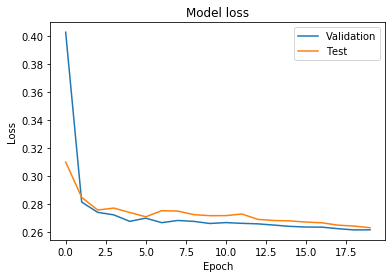

In [83]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Test'], loc='upper right')
plt.show()

In [84]:
j = 0
fuckie = [[[4], [3], [7], [5]]]
fuckie = np.array(fuckie)
fuckie.reshape(1,4,1)

jamie = model.predict_on_batch(fuckie)

In [85]:
#adjusting from normalization
for x in range(12):
    jamie[0][x][0] = abs(jamie[0][x][0] * 11)
    while(jamie[0][x][0] > 127):
        jamie[0][x][0] = jamie[0][x][0] / 10

In [86]:
jamie
#jamie[0][0][0]

array([[[ 7.3604493],
        [ 8.942799 ],
        [ 9.9291115],
        [10.379912 ],
        [10.530971 ],
        [10.5066805],
        [10.3845625],
        [10.216709 ],
        [10.036293 ],
        [ 9.862912 ],
        [ 9.707508 ],
        [ 9.574696 ]]], dtype=float32)

In [87]:
#forced mode
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)
octave = 12 * 5

track.append(Message('program_change', program=2,time=0))
for x in range(5):
    for i in range(12):
        track.append(Message('note_on', note= octave + NoteBins.note_reg(int(jamie[0][i][0])), velocity=64, time=20))
        track.append(Message('note_off', note= octave + NoteBins.note_reg(int(jamie[0][i][0])), velocity=64, time=200))
mid.save('b.mid')

In [88]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('blues.h5')